## RUN THIS NOTEBOOK DIRECTLY IN GOOGLE COLAB
### Upload kaggle.json rest of the things will be uploaded with the help of kaggle api


In [ ]:
!pip install kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json 
!ls ~/.kaggle

#downloading dataset zip files
!kaggle competitions download -c digit-recognizer

#unzipping
!unzip -q "../content/train.csv.zip"
!unzip -q "../content/test.csv.zip"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler

### ENABLE GPU IN COLAB

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
num_epochs = 20
batch_size = 512
learning_rate = 0.0001

### GETTING TRAINING AND TESTING DATA FROM ZIP FILES 
### Normalizing them
### converting to tensors when called

In [ ]:
class CustomedDataSet(torch.utils.data.Dataset):
    def __init__(self, train=True):
        self.train = train
        if self.train :
            trainX = pd.read_csv('train.csv')
            trainY = trainX.label.to_numpy().tolist()
            trainX = trainX.drop('label',axis=1).to_numpy().reshape(trainX.shape[0], 1, 28, 28)
            trainX = (trainX - 0.1307)/0.3081
            
            self.datalist = trainX
            self.labellist = trainY
        else:
            testX = pd.read_csv('test.csv')
            testX = (testX - 0.1307)/0.3081
            testX = testX.to_numpy().reshape(testX.shape[0], 1, 28, 28)
            self.datalist = testX
            
    def __getitem__(self, index):
        if self.train:
            return torch.Tensor(self.datalist[index].astype(float)),self.labellist[index]
        else:
            return torch.Tensor(self.datalist[index].astype(float))
    
    def __len__(self):
        return self.datalist.shape[0]

### Getting training dataset in train_dataset

In [ ]:
train_dataset = CustomedDataSet()

### Splitting the known dataset into training and validation set in order to get best fit of hyperparameters laater on we need to train on whole given data

In [ ]:
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

### Getting data on which we have to make predictions

In [ ]:
test_dataset = CustomedDataSet(train=False)

### Dataloader has been used to parallelize the data loading as this boosts up the speed and saves memory.

In [ ]:
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
#                                            batch_size=batch_size,
#                                            shuffle=True,
#                                            num_workers=2)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                                sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

### Defining cnn class 

In [ ]:
import torch.nn as nn
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.LeakyReLU(0.02),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout(0.5)
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.LeakyReLU(0.02),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout(0.5)
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

### Defining training model with the help of gpu

In [ ]:
model = ConvNet()
model.to(device)

### Using Adam optimizer

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Training model on training dataset

In [ ]:
#Train the model
total_step = len(train_loader)
loss_list = []
acc_list = []
acc_list_epoch = []
for epoch in range(num_epochs):
    acc_sum_present_epoch = []
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        # Run the forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append((correct * 100)/ total)
        acc_sum_present_epoch.append((correct / total) * 100)
        print_after = (int)((dataset_size * 0.8)/(batch_size*3))
        if (i + 1) % print_after == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))
        
        
    
    acc_list_epoch.append(sum(acc_sum_present_epoch)/len(acc_sum_present_epoch))
    #print(acc_sum_present_epoch)
    # for i in range(len(acc_sum_present_epoch)):
    #     print(i," - > ",acc_sum_present_epoch[i])

Epoch [1/20], Step [21/66], Loss: 5.5089, Accuracy: 75.98%
Epoch [1/20], Step [42/66], Loss: 2.5503, Accuracy: 86.72%
Epoch [1/20], Step [63/66], Loss: 1.2027, Accuracy: 90.04%
Epoch [2/20], Step [21/66], Loss: 0.6903, Accuracy: 93.75%
Epoch [2/20], Step [42/66], Loss: 0.6842, Accuracy: 93.36%
Epoch [2/20], Step [63/66], Loss: 0.6711, Accuracy: 93.55%
Epoch [3/20], Step [21/66], Loss: 0.3443, Accuracy: 95.70%
Epoch [3/20], Step [42/66], Loss: 0.4275, Accuracy: 95.31%
Epoch [3/20], Step [63/66], Loss: 0.2246, Accuracy: 96.29%
Epoch [4/20], Step [21/66], Loss: 0.4657, Accuracy: 94.73%
Epoch [4/20], Step [42/66], Loss: 0.2561, Accuracy: 95.70%
Epoch [4/20], Step [63/66], Loss: 0.4804, Accuracy: 91.80%
Epoch [5/20], Step [21/66], Loss: 0.2202, Accuracy: 95.31%
Epoch [5/20], Step [42/66], Loss: 0.2641, Accuracy: 95.90%
Epoch [5/20], Step [63/66], Loss: 0.2803, Accuracy: 94.73%
Epoch [6/20], Step [21/66], Loss: 0.1570, Accuracy: 96.09%
Epoch [6/20], Step [42/66], Loss: 0.1385, Accuracy: 96.0

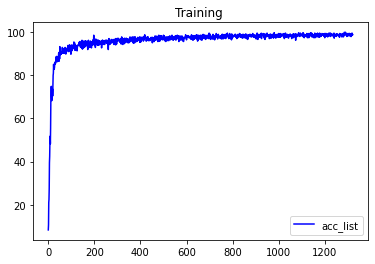

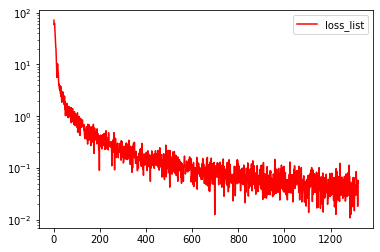

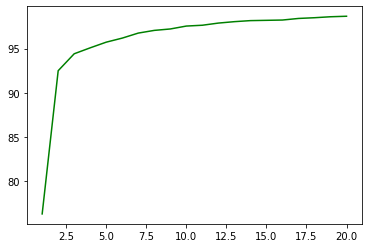

In [ ]:
#accuracy curve
batch_list = range(1,len(acc_list)+1)
plt.plot(batch_list, acc_list, 'b', label='acc_list')
plt.title('Training ')
plt.legend()
plt.show()

plt.plot(batch_list, loss_list, 'r', label='loss_list')

plt.yscale("log") 
plt.legend()
plt.show()

#for each epoch
epoches = range(1,num_epochs+1)
plt.plot(epoches, acc_list_epoch, 'g', label='acc_list_epoch')

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in validation_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Train Acc of the model on training images ',acc_list_epoch[-1])
    print('Test Accuracy of the model on the  validation images: {} %'.format((correct / total) * 100))

Train Acc of the model on training images  98.64050662878788
Test Accuracy of the model on the  validation images: 98.38095238095238 %


In [ ]:
ans = np.array([])
with torch.no_grad():
    correct = 0
    total = 0
    for images in test_loader:
        images = images.to(device)
        outputs = model(images)
        _,predicted = torch.max(outputs.data, 1)
        ans = np.append (ans, predicted.to('cpu').numpy())

In [ ]:
np.savetxt("ans4.csv", np.dstack((np.arange(1, ans.size+1),ans))[0],"%d,%d",header="ImageId,Label",comments="")

In [ ]:
#!kaggle competitions submit -c digit-recognizer -f ans4.csv -m "Message"

In [ ]:
#final model training with 100% data
